This one will get the 2nd order ODEs of the double pendulum into 4 1st order ODEs that are solvable.

In [33]:
import torch
import matplotlib.pyplot as plt
from torchdiffeq import odeint

In [34]:
# Setup some physical parameters
m1 = 1.0 
m2 = 2.25

L1 = 1.3
L2 = 1.7

g = 9.81

In [35]:
#Defining class
class DoublePendy(torch.nn.Module):
    def forward(self, t, y):
        theta1, omega1, theta2, omega2 = y[0], y[1], y[2], y[3]

        dtheta1_dt = omega1
        
        domega1_dt = (-g * (2 * m1 + m2) * torch.sin(theta1) 
                      - m2 * g * torch.sin(theta1 - 2 * theta2)
                      - 2 * torch.sin(theta1 - theta2) * m2 * (omega2**2 * L2 + omega1**2 * L1 * torch.cos(theta1 - theta2))) / (
                             L1 * ( 2 * m1 + m2 - m2 * torch.cos(2 * theta1 - 2 * theta2))
                      )
        
        dtheta2_dt = omega2

        domega2_dt = (
            (
                2 * torch.sin(theta1 - theta2) * 
                (omega1**2 * L1 * (m1 + m2) + g * (m1 + m2) * torch.cos(theta1) + omega2**2 * L2 * m2 * torch.cos(theta1 - theta2))
            ) 
            /
            (
                L2 * ( 2 * m1 + m2 - m2 * torch.cos(2 * theta1 - 2 * theta2))
            )
        )

        return torch.tensor([dtheta1_dt, domega1_dt, dtheta2_dt, domega2_dt])

In [36]:
# inital conditions
theta10 = torch.pi/2
omega10 = 0
theta20 = torch.pi
omega20 = 0

y0 = torch.tensor([theta10, omega10, theta20, omega20])

t_steps = torch.linspace(0, 100, steps = 10000)

In [37]:
model = DoublePendy()
solution = odeint(model, y0, t_steps)

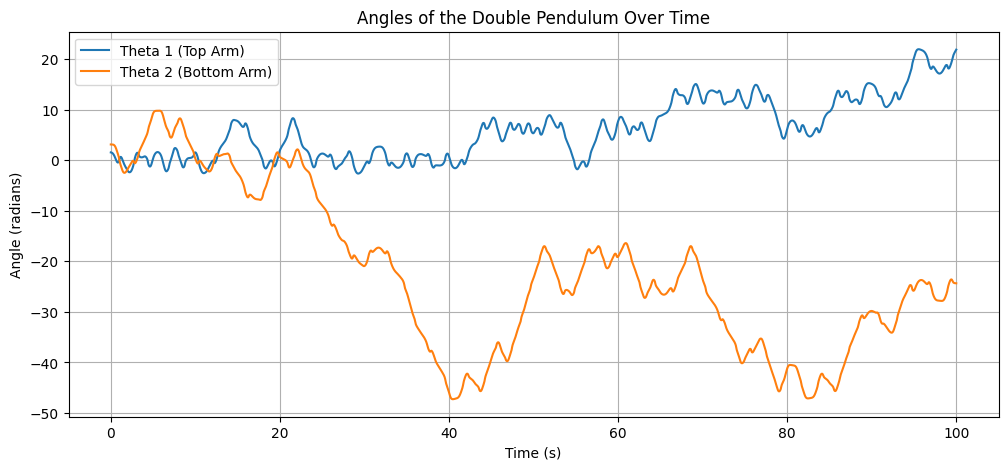

In [38]:
theta1 = solution[:, 0]
theta2 = solution[:, 2]

# Create the time-series plot
plt.figure(figsize=(12, 5))
plt.plot(t_steps.numpy(), theta1.numpy(), label='Theta 1 (Top Arm)')
plt.plot(t_steps.numpy(), theta2.numpy(), label='Theta 2 (Bottom Arm)')
plt.title('Angles of the Double Pendulum Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Angle (radians)')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
import matplotlib.animation as animation
from IPython.display import HTML

# --- Animation Setup ---

# First, convert the angles to Cartesian coordinates
# The solver gives us theta1 and theta2
theta1_sol = solution[:, 0]
theta2_sol = solution[:, 2]

# Calculate the (x, y) positions of the two masses
x1 = L1 * torch.sin(theta1_sol)
y1 = -L1 * torch.cos(theta1_sol)
x2 = x1 + L2 * torch.sin(theta2_sol)
y2 = y1 - L2 * torch.cos(theta2_sol)

# Set up the figure for animation
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-(L1 + L2) * 1.1, (L1 + L2) * 1.1)
ax.set_ylim(-(L1 + L2) * 1.1, (L1 + L2) * 1.1)
ax.set_aspect('equal')
ax.grid()

# Initialize the plot elements that will be updated in each frame
line, = ax.plot([], [], 'o-', lw=2, markersize=8)
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

# This function is called for each frame of the animation
def animate(i):
    # The points to draw are the pivot, the first mass, and the second mass
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]
    
    line.set_data(thisx, thisy)
    time_text.set_text(f'Time = {t_steps[i]:.1f}s')
    return line, time_text

# Create the animation object
# We can skip frames to make the animation faster (e.g., range(0, len(t_steps), 10))
anim = animation.FuncAnimation(fig, animate, 
                             frames=range(0, len(t_steps), 50), 
                             interval=20, blit=True)

# Display the animation
plt.close(fig) # Prevents a static plot from showing below the animation
HTML(anim.to_jshtml())